In [1]:
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap, Normalize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import os
from tqdm.notebook import tqdm
import glob
from skimage import img_as_float
from skimage.metrics import peak_signal_noise_ratio
from matplotlib import pyplot as plt
from skimage import io
from scipy import ndimage as nd
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                denoise_wavelet, denoise_nl_means, estimate_sigma)
from medpy.filter.smoothing import anisotropic_diffusion
import bm3d

C:\Users\desuo\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Composição (MIAs)

In [990]:
pan_images = ["imagens/51.png", "imagens/54.png", "imagens/57.png", "imagens/56.png"]

In [991]:
#Use for MIA000
def combine_pan(pan_images, image_name):
    img1 = cv2.imread(pan_images[0], -1)
    img2 = cv2.imread(pan_images[1], -1)
    img3 = cv2.imread(pan_images[2], -1)
    img4 = cv2.imread(pan_images[3], -1)
    
    img_row_1 = cv2.hconcat([img1, img2])
    img_row_2 = cv2.hconcat([img3, img4])
    combined_pan = cv2.vconcat([img_row_1, img_row_2 ])
    
    return cv2.imwrite(image_name, combined_pan)

In [992]:
combine_pan(pan_images, "output/MIA000.png")

True

In [2]:
img_list = ["imagens/11.png", "imagens/3.png"]

In [3]:
#Use for MIA001,2,3,4,5,6,7,8,9,10, planta and mamas
def combine(img_list, image_name):
    if len(img_list) == 1:
        img1 = cv2.imread(img_list[0], -1)
        return cv2.imwrite(image_name, img1)
    
    if len(img_list) == 2:
        img1 = cv2.imread(img_list[0], -1)
        img2 = cv2.imread(img_list[1], -1)
        combined_duo = cv2.hconcat([img1, img2])
        return cv2.imwrite(image_name, combined_duo)
    
    elif len(img_list) == 3:
        img1 = cv2.imread(img_list[0], -1)
        img2 = cv2.imread(img_list[1], -1)
        img3 = cv2.imread(img_list[2], -1)
        combined_trio = cv2.hconcat([img1, img2, img3])
        return cv2.imwrite(image_name, combined_trio)
    
    else:
        print("for panoram use combine_pan")

In [4]:
combine(img_list, "output/MIA001.png")

True

## Cropping (se necessário)

In [ ]:
#cropping borders in %
mia = cv2.imread("imagens/MIA000.png", -1)
y = 0
x = 0
h = mia.shape[0]
w = mia.shape[1]
mia = mia[x:280, y:w]
mia = mia[120:mia.shape[0], y:w]
cv2.imwrite("output/MIA001_cropped.png", mia)
print(h, w)

## Funcoes de conversao

In [5]:
#IMG TO RAW
def img_to_raw(raw):
    b = raw[:, :, 0]
    g = raw[:, :, 1]
    raw = g*256 + b
    return raw

In [6]:
#RAW TO TEMP
def temp2flir(raw):
    M = 0.02569698246480104
    B = 64.74694198003411
    temp = raw*M - B
    return temp

## Escolher Pallette

In [7]:
##CONVERSAO Pallettes .PAL CMAP
df = pd.DataFrame()
file1 = "pallettes/rain_PDKTAHC.pal"
file2 = "pallettes/hotcolddigital.pal"
file3 = "pallettes/1_brasa.pal"
file4 = "pallettes/hulk_beta.pal"
file5 = "pallettes/RAIN.pal"

In [8]:
with open(file5, 'r') as f:
    for line in f.readlines():
        color = line[:line.find(':')].lower()
        line  = line[line.find(':')+1:]
        row = line.strip()
        values = line.split()
        s = pd.Series(data=values).astype('int')
        df = df.append(s, ignore_index=True)

In [9]:
colors=[]
for r, g, b in zip(df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2]):
    colors.append((r/255, g/255, b/255))

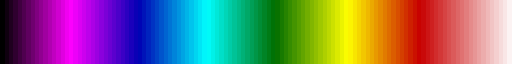

In [10]:
cmap = LinearSegmentedColormap.from_list(file5, colors, N=max(df.index)-min(df.index))
norm = Normalize(vmin=min(df.index), vmax=max(df.index))
cmap

## Aplicacao do Filtro

In [11]:
#OPEN IMAGE
img_noisy = cv2.imread("output/MIA001.png", -1)
img_noisy_raw = img_to_raw(img_noisy)

In [12]:
#APLICACAO FILTRO NLM
sigma_est = np.mean(estimate_sigma(img_noisy_raw, multichannel=False))

NLM_skimg_denoise_img = denoise_nl_means(img_noisy_raw, h=1.15*sigma_est, fast_mode=True, patch_size=9,
                                        patch_distance=5, multichannel=False)

C:\Users\desuo\AppData\Local\Temp\ipykernel_2700\974984065.py:4: UserWarning: Image dtype is not float. By default denoise_nl_means will assume you want to preserve the range of your image (preserve_range=True). In scikit-image 0.19 this behavior will change to preserve_range=False. To avoid this warning, explicitly specify the preserve_range parameter.
  NLM_skimg_denoise_img = denoise_nl_means(img_noisy_raw, h=1.15*sigma_est, fast_mode=True, patch_size=9,


In [13]:
GAU_skimg_denoise_img = nd.gaussian_filter(img_noisy_raw, sigma=1.5)

In [14]:
NLM_skimg_denoise_img = temp2flir(NLM_skimg_denoise_img)
GAU_skimg_denoise_img = temp2flir(GAU_skimg_denoise_img)

## Janelamento

In [16]:
###INTERACTIVE SLIDER - define limits 
%matplotlib tk
fig, ax = plt.subplots()
im = ax.imshow(NLM_skimg_denoise_img, cmap=cmap)
cbar = plt.colorbar(im)


# Add Sliders
c_min = np.min(NLM_skimg_denoise_img)-2 #the min and max range of the sliders
c_max = np.max(NLM_skimg_denoise_img)+2

ax_cmin = plt.axes([0.25, 0.002, 0.65, 0.03]) #positions sliders beneath plot
ax_cmax  = plt.axes([0.25, 0.04, 0.65, 0.03])

s_cmin = Slider(ax_cmin, 'min', c_min, c_max, valinit=c_min) #defines sliders
s_cmax = Slider(ax_cmax, 'max', c_min, c_max, valinit=c_max)

def update(val):
    _cmin = s_cmin.val
    _cmax = s_cmax.val
    im.set_clim([_cmin, _cmax])
    im.update()
    
s_cmin.on_changed(update)
s_cmax.on_changed(update)

resetax = plt.axes([0.12, 0.9, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    s_cmin.reset()
    s_cmax.reset()
button.on_clicked(reset)

quitax = plt.axes([0.23, 0.9, 0.1, 0.04])
quit_button = Button(quitax, 'Quit', hovercolor='0.975')

def quit(event):
    plt.close()

quit_button.on_clicked(quit)

plt.show()

## Salvar Imagen para o Laudo

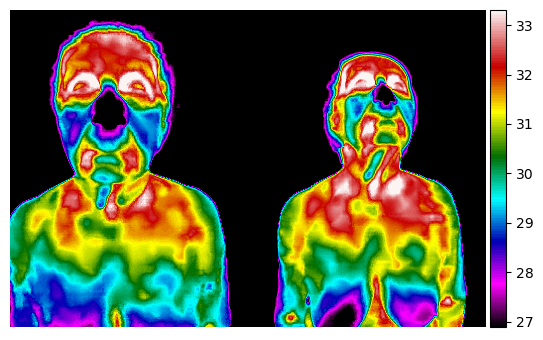

In [17]:
%matplotlib inline
kwargs = {"vmin": s_cmin.val, "vmax": s_cmax.val}
fig = plt.figure() # Your image (W)idth and (H)eight in inches
# Stretch image to full figure, removing "grey region"
#plt.subplots_adjust(left = 0, right = 1, top = 1, bottom = 0)
im = plt.imshow(NLM_skimg_denoise_img, cmap=cmap, **kwargs) # Show the image
#pos = fig.add_axes([0.93,0.1,0.02,0.35]) # Set colorbar position in fig
plt.axis('off')
fig.colorbar(im, fraction=0.032, pad=0.01) # Create the colorbar
plt.savefig('output/MIA001_final.png', bbox_inches="tight")